## Imports

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from pmlb import classification_dataset_names, regression_dataset_names
import numpy as np
from sklearn import datasets
from JOPLEn.singletask import JOPLEn
from JOPLEn.enums import *
from sklearn.ensemble import (
    ExtraTreesRegressor,
    ExtraTreesClassifier,
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingRegressor,
    GradientBoostingClassifier,
    AdaBoostRegressor,
    AdaBoostClassifier,
)
from sklearn.linear_model import LinearRegression
from lineartree import (
    LinearForestRegressor,
    LinearForestClassifier,
    LinearBoostRegressor,
    LinearBoostClassifier,
)
from JOPLEn.ablation import Booster
import lineartree as lt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor, DummyClassifier
from itertools import product
import warnings
from collections import defaultdict
from linear_operator.utils.warnings import NumericalWarning
from sklearn.linear_model import Ridge, RidgeClassifier

# Hide future warnings because ax uses deprecated functions from pandas
warnings.simplefilter(action="ignore", category=FutureWarning)
# Hide unfixable warning from ax (warns about default behavior but there isn't
# a clear way to turn the warning off)
warnings.simplefilter(action="ignore", category=UserWarning)
# Ax gives warning about non PSD matrix.
# TODO: Should I fix this?
warnings.simplefilter(action="ignore", category=NumericalWarning)
from ax import optimize
from pathlib import Path
from copy import copy, deepcopy
import yaml
import time
from pprint import pprint
from ax.service.ax_client import AxClient, ObjectiveProperties
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import logging
from ax.utils.common.logger import ROOT_STREAM_HANDLER
from JOPLEn.partitioner import (
    VPartition,
    GBPartition,
    RFPartition,
    VarMaxForestPartition,
    LinearForestPartition,
    LinearBoostPartition,
)
from JOPLEn.singletask import SquaredError, LogisticLoss
from JOPLEn.enums import CellModel
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from nn import NN
from sklearn.metrics import log_loss, roc_auc_score, zero_one_loss
from sklearn.base import ClassifierMixin

import sys

fastel_path = Path().resolve().parent
sys.path.append(str(fastel_path))

from FASTEL.src.engine import MultiTaskTrees
from sklearn.preprocessing import LabelEncoder

ROOT_STREAM_HANDLER.setLevel(logging.ERROR)

CACHE_DIR = Path("ax_runs") / "prediction"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

DS_PATH = Path("..") / "datasets" / "pmlb" / "processed"
PARAM_PATH = Path(".") / "parameters"
PLOT_PATH = Path(".") / "plots"

2024-03-03 10:48:42.494266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 10:48:42.494289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 10:48:42.495012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# too many samples, causes JOPLEn to crash
EXCLUDE = [
    # regression
    "1191_BNG_pbc",
    "215_2dplanes",
    "1201_BNG_breastTumor",
    "1196_BNG_pharynx",
    "1595_poker",
    "1203_BNG_pwLinear",
    "594_fri_c2_100_5",
    "218_house_8L",
    "1193_BNG_lowbwt",
    "537_houses",
    "564_fried",
    "344_mv",
    "574_house_16H",
    "573_cpu_act",
    "562_cpu_small",
    "1199_BNG_echoMonths",
    "294_satellite_image",
    "197_cpu_act",
    "201_pol",
    "227_cpu_small",
    "503_wind",
    # classification
    "Hill_Valley_with_noise",
    "Hill_Valley_without_noise",
    "breast_cancer_wisconsin",
    "appendicitis",
    "prnn_synth",
    "sonar",
    "phoneme",
    "twonorm",
    "magic",
    "wdbc",
    "adult",
]

## Parameters

In [3]:
model_info = {
    "regression": {},
    "classification": {},
}

for t in ["regression", "classification"]:
    for model in (PARAM_PATH / t).glob("*.yaml"):
        model_info[t][model.stem] = yaml.safe_load(open(model, "r"))

## Training Functions

In [4]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


def auc(y_true, y_pred):
    if len(set(y_true)) == 2:
        return float(roc_auc_score(y_true, y_pred))
    else:
        return None


# # TODO: Need to check that classification is -1,1 vs 0,1 and handle appropriately
# def zoloss(y_true, y_pred):
#     if set(y_true) == {0, 1}:
#         return float(zero_one_loss(y_true, y_pred))
#     else:
#         return None


loss_dict = {
    "mse": rmse,
    "rmse": rmse,
    "log_loss": log_loss,
    "binary": log_loss,
    True: log_loss,
    False: rmse,
}


def loss(y_true, y_pred, loss):
    return float(loss_dict[loss](y_true, y_pred))


def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time

        return (result, start_time, end_time, elapsed_time)

    return wrapper


@timer_decorator
def train_lgbm(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
):
    model = ModelClass(**params)

    is_classifier = issubclass(ModelClass, ClassifierMixin)

    model.fit(
        x_train,
        y_train.flatten(),
        # TODO: Need to re-enable validation set
        eval_set=[(x_val, y_val.flatten())],
        # verbose=-1,
        callbacks=[],
    )

    val_pred = (
        model.predict_proba(x_val)[:, 1] if is_classifier else model.predict(x_val)
    )

    val_error = loss(y_val, val_pred, params["objective"])

    if x_test is not None and y_test is not None:
        y_pred = (
            model.predict_proba(x_test)[:, 1]
            if is_classifier
            else model.predict(x_test)
        )

        test_error = loss(y_test, y_pred, params["objective"])

        return (
            val_error,
            test_error,
            model,
            {"auc": auc(y_test, y_pred)},
        )
    else:
        return val_error, model


@timer_decorator
def train_sklearn(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
    rescale=False,
):
    if rescale:
        model = Pipeline(
            [("scaler", StandardScaler()), ("model", ModelClass(**params))]
        )
    else:
        model = ModelClass(**params)

    model.fit(x_train, y_train.flatten())

    is_classification = issubclass(ModelClass, ClassifierMixin)

    if is_classification:
        val_error = loss(y_val, model.predict_proba(x_val)[:, 1], True)
    else:
        val_error = loss(y_val, model.predict(x_val), is_classification)

    if x_test is not None and y_test is not None:
        if is_classification:
            y_pred = model.predict_proba(x_test)[:, 1]
        else:
            y_pred = model.predict(x_test)

        test_error = loss(y_test, y_pred, True)

        return (
            val_error,
            test_error,
            model,
            {
                "auc": auc(y_test, y_pred),
            },
        )
    else:
        return val_error, model


def train_gbr(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
):
    return train_sklearn(
        ModelClass,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_rfr(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
):
    return train_sklearn(
        ModelClass,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_etr(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
):
    return train_sklearn(
        ModelClass,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


# TODO: compare JOPLEn to AdaBoost
def train_abr(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
):
    return train_sklearn(
        ModelClass,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_lf(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
):
    return train_sklearn(
        ModelClass,
        {**params, "base_estimator": LinearRegression()},
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_ridge(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
):
    return train_sklearn(
        ModelClass,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        rescale=True,
    )


@timer_decorator
def train_pen(
    ModelType,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
):
    params = deepcopy(params)
    is_classification = eval(params["loss_fn"]) == LogisticLoss

    initial_params = {
        "partitioner": eval(params.pop("partitioner")),
        "n_cells": params.pop("n_cells"),
        "n_partitions": params.pop("n_partitions"),
        "random_state": params.pop("random_state"),
    }

    if "cell_model" in params:
        initial_params["cell_model"] = eval(params.pop("cell_model"))

    model = ModelType(
        loss_fn=eval(params.pop("loss_fn")),
        **initial_params,
    )

    if "norm_type" in params:
        params["norm_type"] = eval(params["norm_type"])

    history = model.fit(
        x_train,
        y_train,
        val_x=x_val,
        val_y=y_val,
        **params,
    )

    val_error = loss(y_val, model.predict(x_val), is_classification)

    if x_test is not None and y_test is not None:
        y_pred = model.predict(x_test)
        test_error = loss(y_test, y_pred, is_classification)
        return (
            val_error,
            test_error,
            model,
            {
                "n_epochs": (
                    len(history["objective"]) if "objective" in history else None
                ),
                "auc": auc(y_test, y_pred),
            },
        )
    else:
        return val_error, model


def train_joplen(
    _,  # ModelClass is not used
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
):
    return train_pen(
        JOPLEn,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


@timer_decorator
def train_fastel(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
):
    assert (
        params["loss_criteria"] != "log_loss"
    ), "FASTEL does not support the logistic loss"

    xs = StandardScaler().fit(x_train)
    x_train = xs.transform(x_train)
    x_val = xs.transform(x_val)
    x_test = xs.transform(x_test) if x_test is not None else None

    ys = StandardScaler().fit(y_train.reshape(-1, 1))
    y_train = ys.transform(y_train.reshape(-1, 1))
    y_val = ys.transform(y_val.reshape(-1, 1))
    y_test = ys.transform(y_test.reshape(-1, 1)) if y_test is not None else None

    model = MultiTaskTrees(
        input_shape=x_train.shape[1:],
        **params,
    )

    model.train(
        x_train,
        y_train.reshape(-1, 1),
        np.ones((y_train.shape[0], 1)),
        x_val,
        y_val.reshape(-1, 1),
        np.ones((y_val.shape[0], 1)),
    )

    y_val_pred = ys.inverse_transform(model.predict(x_val)[:, None])
    val_error = loss(y_val, y_val_pred.flatten(), params["loss_criteria"])

    if x_test is not None and y_test is not None:
        y_test_pred = ys.inverse_transform(model.predict(x_test)[:, None])
        test_error = loss(y_test, y_test_pred.flatten(), params["loss_criteria"])
        return val_error, test_error, model, {}
    else:
        return val_error, model


@timer_decorator
def train_nn(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test=None,
    y_test=None,
):
    # TODO: should rescale the y values as well
    xs = StandardScaler().fit(x_train)

    loss_criteria = params.pop("loss_criteria")

    assert loss_criteria == "mse"

    tmp_params = deepcopy(params)

    model = NN(
        hidden_layer_size=tmp_params.pop("hidden_layer_size"),
        n_hidden_layers=tmp_params.pop("n_hidden_layers"),
        activation=tmp_params.pop("activation"),
        sel_feat=False,
    )
    model.fit(
        xs.transform(x_train),
        y_train,
        xs.transform(x_val),
        y_val,
        **tmp_params,
    )

    y_val_pred = model.predict(xs.transform(x_val))
    val_error = loss(y_val, y_val_pred.flatten(), loss_criteria)

    if x_test is not None and y_test is not None:
        y_test_pred = model.predict(xs.transform(x_test))
        test_error = loss(y_test, y_test_pred.flatten(), loss_criteria)
        return val_error, test_error, model, {}
    else:
        return val_error, model

In [5]:
def dummy_prediction(
    x_train,
    x_val,
    x_test,
    y_train,
    y_val,
    y_test,
    is_classification,
):
    if is_classification:
        dummy = DummyClassifier(strategy="most_frequent")
    else:
        dummy = DummyRegressor(strategy="mean")

    dummy.fit(x_train, y_train)
    y_pred = dummy.predict(x_test)

    res = {
        "model_name": dummy.__class__.__name__,
        "loss": loss(y_test, y_pred, is_classification),
    }

    return res

## Run Experiments

In [6]:
def contains_categorical(arr: np.ndarray) -> bool:
    """Checks if an array contains categorical, ordinal, binary, or nominal features"""
    return bool(np.any(np.all(np.mod(arr, 1) == 0, axis=0)))


train_fn = {
    LGBMRegressor.__name__: train_lgbm,
    LGBMClassifier.__name__: train_lgbm,
    GradientBoostingRegressor.__name__: train_gbr,
    GradientBoostingClassifier.__name__: train_gbr,
    RandomForestRegressor.__name__: train_rfr,
    RandomForestClassifier.__name__: train_rfr,
    ExtraTreesRegressor.__name__: train_etr,
    ExtraTreesClassifier.__name__: train_etr,
    JOPLEn.__name__: train_joplen,
    LinearForestRegressor.__name__: train_lf,
    LinearForestClassifier.__name__: train_lf,
    Ridge.__name__: train_ridge,
    MultiTaskTrees.__name__: train_fastel,
    NN.__name__: train_nn,
}


def optimize_model(model_info, ds_path, n_trials, skip_categorical, is_classification):
    ds_name = ds_path.name
    params = model_info["parameters"]
    loss_type = "log_loss" if is_classification else "rmse"

    dir_path = (
        CACHE_DIR
        / ("class" if is_classification else "regr")
        / model_info["dir_name"]
        / ds_name
    )
    exp_path = dir_path / "experiment.json"
    metadata_path = dir_path / "metadata.yaml"

    if metadata_path.exists():
        with open(metadata_path, "r") as f:
            metadata = yaml.load(f, Loader=yaml.FullLoader)

        # Add missing metadata without rerunning everything
        if contains_categorical not in metadata:
            metadata["contains_categorical"] = contains_categorical(
                np.loadtxt(ds_path / "x_train.csv", delimiter=",")
            )

            # update metadata
            with open(metadata_path, "w") as f:
                yaml.dump(metadata, f)

        return metadata

    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(ds_path / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(ds_path / "x_test.csv", delimiter=",")
    y_train = np.loadtxt(ds_path / "y_train.csv", delimiter=",")
    y_val = np.loadtxt(ds_path / "y_val.csv", delimiter=",")
    y_test = np.loadtxt(ds_path / "y_test.csv", delimiter=",")

    if is_classification:
        enc = LabelEncoder()
        y_train = enc.fit_transform(y_train)
        y_val = enc.transform(y_val)
        y_test = enc.transform(y_test)

    bl_categorical = contains_categorical(x_train)

    if bl_categorical and skip_categorical:
        return None

    if bl_categorical and not model_info["is_constant"]:
        return None

    # print(ds_name)

    dummy_info = dummy_prediction(
        x_train,
        x_val,
        x_test,
        y_train,
        y_val,
        y_test,
        is_classification=is_classification,
    )

    if not exp_path.exists():
        ax_client = AxClient(
            random_seed=0,
            verbose_logging=False,
        )

        ax_client.create_experiment(
            name=f"{model_info['model']}_{ds_name}",
            parameters=params,
            objectives={loss_type: ObjectiveProperties(minimize=True)},
            overwrite_existing_experiment=True,
        )

        for _ in trange(n_trials, leave=False, position=1):
            round_params, trial_index = ax_client.get_next_trial()

            try:
                val_error, _ = train_fn[model_info["model"]](
                    eval(model_info["model"]),
                    round_params,
                    x_train=x_train,
                    y_train=y_train,
                    x_val=x_val,
                    y_val=y_val,
                )[0]
                ax_client.complete_trial(
                    trial_index=trial_index, raw_data=float(val_error)
                )
            except ValueError as e:
                print(e)
                ax_client.abandon_trial(
                    trial_index=trial_index,
                    reason=str(e),
                )
    else:
        ax_client = AxClient.load_from_json_file(filepath=exp_path)

    best_parameters, values = ax_client.get_best_parameters()

    (val_error, test_error, model, metadata), _, _, train_time = train_fn[
        model_info["model"]
    ](
        eval(model_info["model"]),
        best_parameters,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        x_test=x_test,
        y_test=y_test,
    )

    exp_path.parent.mkdir(parents=True, exist_ok=True)

    ax_client.save_to_json_file(
        filepath=exp_path,
    )

    metadata = {
        "model_name": model_info["model"],
        "val_score": float(val_error),
        "test_score": float(test_error),
        "train_time": float(train_time),
        "params": best_parameters,
        "dummy_loss": float(dummy_info["loss"]),
        "contains_categorical": bl_categorical,
        **metadata,
    }

    with open(metadata_path, "w") as f:
        yaml.dump(metadata, f)

    return metadata

In [7]:
ignored_models = [
    "joplen_const_gb_part_l1",
    "fastel",
    "joplen_const",
    "joplen_linear_inf",
    # "joplen_const_gb_part_l2",
    "joplen_const_gb_part_l1",
    "joplen_const_gb_part_sl2",
    "joplen_const_gb_part",
    # "joplen_const_gb_part",
    "joplen_const_rf_part",
    # "rf",
    # "et",
    # "lgbm",
    "lf",
]

reg_datasets = [d for d in (DS_PATH / "reg").iterdir() if d.is_dir()]
class_datasets = [d for d in (DS_PATH / "class").iterdir() if d.is_dir()]

reg_res = defaultdict(dict)

for name, lst in zip(["regression", "classification"], [reg_datasets, class_datasets]):
    print(f"Running {name} datasets")

    itr = tqdm(lst, position=0)

    for ds_path in itr:
        if ds_path.name in EXCLUDE:
            continue

        for file_name, info in model_info[name].items():
            if file_name in ignored_models:
                continue

            model_str = f"{file_name} on {ds_path.name}"
            itr.set_description(f"Running {model_str : <50}")
            res = optimize_model(info, ds_path, 50, False, name == "classification")

            if res is not None:
                reg_res[info["name"]][ds_path.name] = res

reg_res = dict(reg_res)

Running regression datasets


  0%|          | 0/122 [00:00<?, ?it/s]

Running classification datasets


  0%|          | 0/90 [00:00<?, ?it/s]

{'Linear forest': 0.04185482966237708, 'JOPLEn (constant, GB partitions, l2)': 0.032637786121367904, 'Gradient Boosting': 0.02801881795899497}


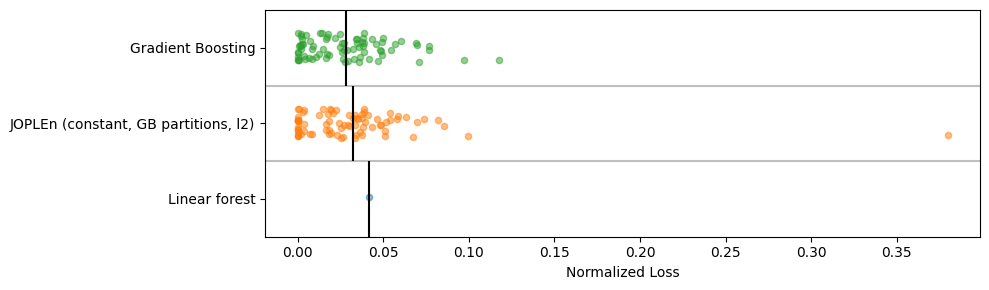

In [13]:
def plot_strip(
    reg_res: dict,
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
    only_classification: bool = False,
):
    """
    Create a strip plot based on the list of y-values.
    """
    x_values = []
    y_labels = []

    rescaled_res = {
        k: {
            kk: (vv["test_score"] / vv["dummy_loss"])
            for kk, vv in v.items()
            if (kk in classification_dataset_names) == only_classification
        }
        for k, v in reg_res.items()
    }

    rescaled_res = {k: v for k, v in rescaled_res.items() if len(v) > 0}

    mean_res = {k: np.mean(list(v.values())) for k, v in rescaled_res.items()}

    sorted_dict = {k: rescaled_res[k] for k in sorted(mean_res, key=mean_res.get)[::-1]}

    for k, v in sorted_dict.items():
        x_values.append(v.values())
        y_labels.append(k)

    fig, ax = plt.subplots(figsize=(10, len(rescaled_res)), **plot_kwargs)

    for x_idx, val in enumerate(x_values):
        np.random.seed(random_state)
        # Apply jitter to x-axis positions
        y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in val]
        ax.scatter(val, y_values, **scatter_kwargs)

    x_lim = ax.get_xlim()

    for x_idx, val in enumerate(x_values[:-1]):
        ax.hlines(x_idx + 1 / 2, *x_lim, color="k", alpha=0.25)

    # plot vertical line for mean for each model
    means = [np.mean(list(val)) for val in x_values]
    for x_value, mean in zip(range(len(x_values)), means):
        ax.vlines(mean, x_value - 1 / 2, x_value + 1 / 2, color="k")

    ax.set_xlim(x_lim)

    print({k: v for k, v in zip(y_labels, means)})

    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels)

    y_lim = ax.get_ylim()
    ax.vlines(1, -1, len(y_labels) + 1, color="k", linestyle="--")
    ax.set_ylim(-1 / 2, len(y_labels) - 1 / 2)

    plt.xlabel("Normalized Loss")

    plt.tight_layout()

    return ax, means


ax, means = plot_strip(
    reg_res,
    scatter_kwargs={"alpha": 0.5, "s": 20},
    only_classification=True,
)

plt.savefig(PLOT_PATH / "reg_strip.png", dpi=300)

plt.show()

In [14]:
# compute non-parametic distribution test
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

ours, theirs = [], []

for k, v in reg_res["JOPLEn (constant, GB partitions, l2)"].items():
    if k in reg_res["Gradient Boosting"] and k in classification_dataset_names:
        ours.append(v["test_score"])
        theirs.append(reg_res["Gradient Boosting"][k]["test_score"])

ours = np.array(ours)
theirs = np.array(theirs)

print(mannwhitneyu(ours, theirs, alternative="less"))
print(wilcoxon(ours, theirs, alternative="less"))

MannwhitneyuResult(statistic=3187.0, pvalue=0.5921160709745978)
WilcoxonResult(statistic=1698.0, pvalue=0.7179202201189361)


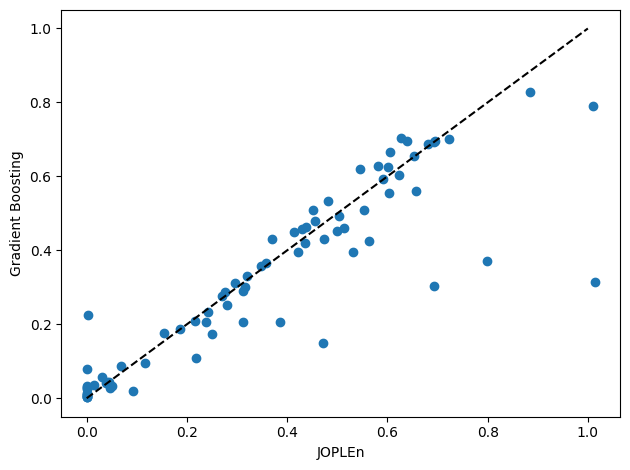

In [10]:
plt.scatter(ours, theirs)
plt.plot([0, 1], [0, 1], color="k", linestyle="--")
plt.xlabel("JOPLEn")
plt.ylabel("Gradient Boosting")
plt.tight_layout()
plt.show()

In [11]:
datasets = list(list(rescaled_res.values())[0].keys())

ratio = ours / theirs
args = np.argsort(ratio)[::-1]

plt.scatter(range(len(ratio)), ratio[args])
plt.hlines(1, 0, len(ratio), color="k", linestyle="--")

plt.xlabel("Dataset")
plt.ylabel("JOPLEn / Gradient Boosting")

plt.show()

print("We do much worse on these datasets")
print([datasets[i] for i in args[:2]])

NameError: name 'rescaled_res' is not defined

- [192_vineyard](https://github.com/EpistasisLab/pmlb/blob/master/datasets/192_vineyard/metadata.yaml): Small dataset, 52 samples, 2 features. May be that we just needed to use a better GB model for selecting splits
- 645_fri_c3_500_50: Not sure what's wrong with this dataset

In [ ]:
shapes = []

for ds_path in reg_datasets:
    if ds_path.name in EXCLUDE:
        continue

    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
    shapes.append(x_train.shape[1])

plt.hist(shapes, bins=20)
plt.ylabel("# features")
plt.xlabel("Frequency")
plt.show()